In [1]:
import os, sys
sys.path.append(os.path.dirname('spritelu/'))
from spriteworld import environment, renderers, sprite, tasks, action_spaces
from spriteworld import factor_distributions as distribs, sprite_generators, gym_wrapper as gymw
import matplotlib.pyplot as plt, copy, numpy as np, os
import multiprocessing as mp
import math
%matplotlib inline
from matplotlib import animation, rc
from IPython.display import HTML

def viz(obs):
  plt.figure(figsize=(2,2))
  plt.imshow(255 - obs)
  
  
def anim(env, T=100):
  fig = plt.figure(figsize=(2,2))
  
  states = [255 - env.reset()['image']]
  
  for i in range(T):
    a = env.action_space.sample()
    state, _, _, _ = env.step(a)
    states.append(255 - state['image'])
  
  im = plt.imshow(states[0], cmap=plt.get_cmap('jet'), vmin=0, vmax=255)
  
  def updatefig(j):
    im.set_array(states[j])
    return [im]
  
  ani = animation.FuncAnimation(fig, updatefig, frames=T, interval=75, repeat_delay=1000)
  return ani.to_html5_video()


np.random.seed(0)

In [2]:
NUM_SPRITES = 4
IMAGEDIM = 16

In [3]:
factors = distribs.Product([
    distribs.Continuous('x', 0.05, 0.95),
    distribs.Continuous('y', 0.05, 0.95),
    distribs.Continuous('c0', 25, 230),
    distribs.Continuous('c1', 25, 230),
    distribs.Continuous('c2', 25, 230),
    distribs.Continuous('x_vel', -0.08, 0.08),
    distribs.Continuous('y_vel', -0.08, 0.08),
    distribs.Discrete('shape', ['square']),
    distribs.Discrete('move_noise', [0.]),
    distribs.Discrete('scale', [0.15]),
  ])

sprite_gen = sprite_generators.generate_nonintersecting_sprites(factors, num_sprites=NUM_SPRITES)
sprite_gen = sprite_generators.sort_by_color(sprite_gen)

# Above code produces random colors but has sensible ordering. 
# Below line forces fixed colors (bad for generalization, but presumably easier to learn from images)

sprite_gen = sprite_generators.fix_colors(sprite_gen, [(250, 125, 0), (0, 255, 125), (125, 0, 255), (255, 255, 255)])

In [4]:
sprite_gen()

In [5]:
from spriteworld import tasks
from scipy.spatial.distance import pdist as pairwise_distance, squareform
class PairwiseDistanceSprites(tasks.AbstractTask):
  """Task is to min/max a function of pairwise distance between all the sprites"""
  
  def __init__(self, mode='max', fn=np.mean):
    if mode == 'max':
      self.coef = 1.
    elif mode == 'min':
      self.coef = -1.
    else:
      raise NotImplementedError
      
    self.fn = fn
    
  def reward(self, sprites):
    """Computes reward from list of sprites"""
    poses = [s.position for s in sprites]
    return self.coef * self.fn(pairwise_distance(poses))
    
    
  def reward_of_vector_repr(self, state_vector):
    """Computes reward on a 'VectorizedPositionsAndVelocities' format"""
    poses = state_vector.reshape(-1, 4)[:,:2]
    return self.coef * self.fn(pairwise_distance(poses))
    
  def success(self, sprites=None):
    return False # never terminates

In [6]:
random_mtx = (np.random.rand(100, 100) - 0.5)*2.
fn=lambda a: np.dot(random_mtx[:len(a),:len(a)], a)

# WARNING: Because this uses velocity, using images makes it a POMDP! 

rndrs = {
      'image': renderers.PILRenderer(image_size=(IMAGEDIM, IMAGEDIM), anti_aliasing=16),
      'disentangled': renderers.VectorizedPositionsAndVelocities(),
      'entangled': renderers.FunctionOfVectorizedPositionsAndVelocities(fn=fn),
      'mask': renderers.TransitionEntanglementMask(state_size=4, action_size=2),
      'mask_abstract': renderers.TransitionEntanglementMask(state_size=1, action_size=1)
  }

In [7]:
config = {
    'task': PairwiseDistanceSprites(),
    'action_space': action_spaces.SelectBounce(),
    'renderers': rndrs,
    'init_sprites': sprite_gen,
    'max_episode_length': 5000,
    'metadata': {
        'name': 'test', #os.path.basename(__file__),
    }
}

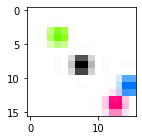

In [8]:
env = environment.Environment(**config)
env = gymw.GymWrapper(env)
viz(env.reset()['image'])

In [9]:
env.reset()['disentangled']

array([[ 0.30498597,  0.58430934,  0.03271548,  0.01462365],
       [ 0.49069604,  0.31466594, -0.02460473, -0.00738784],
       [ 0.8707908 ,  0.49486   , -0.03972454,  0.0076259 ],
       [ 0.7567534 ,  0.5504677 ,  0.05612702,  0.07605436]],
      dtype=float32)

In [10]:
env.reset()['entangled']

array([-1.93239967,  1.111718  , -0.38313292, -0.2208284 , -1.61423495,
        0.33585029, -0.01531999,  0.78421353,  1.40934281,  0.12736371,
       -0.52857223, -0.03528211,  1.4219999 ,  0.32813116,  2.27609927,
       -0.65045224])

In [11]:
env.reset()
env.step(env.action_space.sample())[0]['mask'].shape

(18, 18)

In [12]:
env.reset()
env.step(env.action_space.sample())[0]['mask_abstract']

array([[1., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 1., 0., 0.],
       [1., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.]])

In [13]:
from scipy.linalg import block_diag
state_block = np.ones((4,4))
a = block_diag(*([state_block] * NUM_SPRITES + [np.zeros((2,2))]))

total = 0
for _ in range(10):
  env.reset()
  for i in range(100):
    if np.all(a == env.step(env.action_space.sample())[0]['mask']):
      total +=1

print(total, 'out of 1000 transitions were disentangled')

845 out of 1000 transitions were disentangled


In [14]:
res = anim(env, 200)
plt.close()
HTML(res)

In [15]:
def create_factorized_dataset(num_transitions=20000, reset_prob=0.05, print_every=1000):
  data = []
  sprites = []
  s1 = env.reset()
  sprites1 = copy.deepcopy(env._env.state()['sprites'])
  i = 1
  while len(data) < num_transitions:
    i += 1
    if i % print_every == 0:
      print('.',end='',flush=True)
    a = env.action_space.sample()
    s2, r, _, _ = env.step(a)
    
    data.append((s1['disentangled'], a, r, s2['disentangled']))
    sprites.append(sprites1)
    
    s1 = s2
    sprites1 = copy.deepcopy(env._env.state()['sprites'])
    
    if np.random.random() < reset_prob:
      s1 = env.reset()
      sprites1 = copy.deepcopy(env._env.state()['sprites'])
  return data, sprites

In [16]:
data, sprites = create_factorized_dataset(2000)
test_data, test_sprites = create_factorized_dataset(5000)

.......

In [17]:
from scipy.sparse.csgraph import connected_components
from itertools import combinations, chain
from functools import reduce

def powerset(n):
  xs = list(range(n))
  return list(chain.from_iterable(combinations(xs,n) for n in range(n+1)))

def get_true_abstract_mask(sprites, action=(0.5, 0.5)):
  """Returns a mask with iteractions for next transition given true sprites. 
  E.g., returns [[1,0,0],[0,1,0],[0,0,1]] for 3 sprites"""
  sprites1 = copy.deepcopy(sprites)
  config['action_space'].step(action, sprites1)
  return config['renderers']['mask_abstract'].render(sprites1)

def get_true_flat_mask(sprites, action=(0.5, 0.5)):
  """Returns a mask with iteractions for next transition given true sprites. 
  E.g., returns [[1,0,0],[0,1,0],[0,0,1]] for 3 sprites"""
  sprites1 = copy.deepcopy(sprites)
  config['action_space'].step(action, sprites1)
  return config['renderers']['mask'].render(sprites1)

def get_random_flat_mask(sprites, action=(0.5, 0.5)):
  sprites1 = copy.deepcopy(sprites)
  config['action_space'].step(action, sprites1)
  mask = config['renderers']['mask'].render(sprites1)
  return np.eye(len(mask))

def get_fully_connected_mask(sprites, action=(0.5, 0.5)):
  sprites1 = copy.deepcopy(sprites)
  config['action_space'].step(action, sprites1)
  mask = config['renderers']['mask'].render(sprites1)
  return np.ones(mask.shape)

def cc_list(cc):
  """Converts return of scipy's connected_components into a list of
  connected component indices tuples. 
  E.g., if there are 4 nodes in the graph,
  this might return [array([0]), array([1]), array([2, 3])]
  """
  res = []
  num_ccs, cc_idxs = cc
  for i in range(num_ccs):
    res.append(np.where(cc_idxs == i)[0])
  return res

def get_cc_from_sprites_and_action(sprites, action=(0.5, 0.5), get_mask=get_true_abstract_mask):
  """Returns list of connected component indices for next transition interactions \
  given true sprites. 
  
  E.g., if mask is [[1,0,0,0],[0,1,0,0],[0,0,1,1],[0,0,1,1]], 
  this will return [array([0]), array([1]), array([2, 3])]
  """
  return cc_list(connected_components(get_mask(sprites, action)))

def reduce_cc_list_by_union(cc_list, max_ccs):
  """Takes a cc list that is too long and merges some components to bring it to max_ccs"""
  while len(cc_list) > max_ccs:
    i, j = np.random.choice(range(1,len(cc_list)-1), 2, replace=False)
    if (j == 0) or (j == len(cc_list) - 1):
      continue # don't want to delete the base
    cc_list[i] = np.union1d(cc_list[i], cc_list[j])
    del cc_list[j]
  return cc_list

def disentangled_components(cc_lst, max_components = 5):
  """Converts a connected component list into a list of disentangled subsets of the indices.
  E.g. if """
  subsets = powerset(len(cc_lst))
  res = []
  for subset in subsets:
    res.append(reduce(np.union1d, [cc_lst[i] for i in subset], np.array([])).astype(np.int64))
  return list(map(tuple, res))

In [17]:
def relabel_independent_transitions(t1, sprites1, t2, sprites2, total_samples=10, flattened=True, 
                                    custom_get_mask=None, sample_multiplier=3, max_ccs=6):
  """
  Takes two transitions with their sprite representation, and combines them 
  using connected-component relabeling
  """
  if flattened:
    get_mask = get_true_flat_mask
  else:
    get_mask = get_true_abstract_mask
    
  if custom_get_mask is not None:
    get_mask = custom_get_mask
    
  s1_1, a_1, _, s2_1 = t1
  s1_2, a_2, _, s2_2 = t2
  action_start = len(s1_1)
  
  if flattened:
    s1_1 = s1_1.flatten()
    s2_1 = s2_1.flatten()
    s1_2 = s1_2.flatten()
    s2_2 = s2_2.flatten()
    action_start = len(s1_1)
    action_idxs = list(range(action_start, action_start+len(a_1)))
  else:
    action_idxs = [action_start]
  
  cc1 = get_cc_from_sprites_and_action(sprites1, a_1, get_mask)
  cc1 = reduce_cc_list_by_union(cc1, max_ccs)
    
  cc2 = get_cc_from_sprites_and_action(sprites2, a_2, get_mask)
  cc2 = reduce_cc_list_by_union(cc2, max_ccs)
  
  dc1 = disentangled_components(cc1)
  dc2 = disentangled_components(cc2)
  res = []
  
  no_relabeling = False
  
  # subsample dc1 according to total_samples * sample multipler
  # sample multiplier is meant to oversample, then we will trim down to total_samples
  if total_samples is not None and len(dc1) > 2:
    dc1 = [()] + list(np.random.choice(dc1[1:], total_samples * sample_multiplier - 1))
  elif total_samples is not None:
    dc1 = dc1 * (total_samples // 2)
    no_relabeling = True
    
  for dc in dc1:
    # First check if this disconnected component is also in the second transitions
    # Else do nothing
    if dc in dc2:
      # Given a match, we try relabeling
      proposed_sprites = copy.deepcopy(sprites1)
      proposed_action  = a_1.copy()
      proposed_s1      = s1_1.copy()
      proposed_s2      = s2_1.copy()
      
      for idx in dc:
        if idx in action_idxs:
          if flattened:
            proposed_action[idx-action_start] = a_2[idx-action_start]
          else:
            proposed_action = a_2
        else:
          proposed_s1[idx] = s1_2[idx]
          proposed_s2[idx] = s2_2[idx]
          if flattened:
            if idx % NUM_SPRITES == 0:
              proposed_sprites[idx // NUM_SPRITES] = copy.deepcopy(sprites2)[idx // NUM_SPRITES]
          else:
            proposed_sprites[idx] = copy.deepcopy(sprites2)[idx]

      # Now we also need to check if the proposal is valid #NOTE: This also uses custom_get_mask
      if not (get_mask in [get_random_flat_mask, get_fully_connected_mask]):
        proposed_cc = get_cc_from_sprites_and_action(proposed_sprites, proposed_action, get_mask)
        proposed_dc = disentangled_components(proposed_cc)
        if dc in proposed_dc:
          res.append((proposed_s1, proposed_action, 0, proposed_s2))
      else:
        res.append((proposed_s1, proposed_action, 0, proposed_s2))
        
  while len(res) < total_samples:
    res.append(res[np.random.choice(len(res))])
  return res[:total_samples]

In [18]:
def relabel(args):
  return relabel_independent_transitions(*args)

def enlarge_dataset(data, sprites, num_pairs, relabel_samples_per_pair, flattened=True, custom_get_mask=None):
  data_len = len(data)
  all_idx_pairs = np.array(np.meshgrid(np.arange(data_len), np.arange(data_len))).T.reshape(-1, 2)
  chosen_idx_pairs_idxs = np.random.choice(len(all_idx_pairs), num_pairs)
  chosen_idx_pairs = all_idx_pairs[chosen_idx_pairs_idxs]
  
  args = []
  for (i, j) in chosen_idx_pairs:
    args.append((data[i], sprites[i], data[j], sprites[j],
                                               relabel_samples_per_pair, flattened, custom_get_mask))
  
  with mp.Pool(min(mp.cpu_count() - 1, 16)) as pool:
    reses = pool.map(relabel, args)
  #reses = map(relabel, args)
    
  return sum(reses, [])

In [19]:
res = enlarge_dataset(data, sprites, 500, 10, flattened=True, custom_get_mask=get_true_flat_mask)
print(len(res))
res[:1] # each is s1, a, r, s2

5000


[(array([ 6.8256652e-01,  2.3284464e-01, -6.3486710e-02, -9.1914371e-06,
          1.6643980e-01,  6.8756992e-01, -4.0526919e-02, -5.3639747e-02,
          2.0590073e-01,  1.3989601e-01, -5.4771252e-02, -3.9049243e-03,
          5.0125170e-01,  6.3511556e-01,  6.1848592e-02,  7.9389445e-02],
        dtype=float32),
  array([0.6798561, 0.85342  ], dtype=float32),
  0,
  array([ 6.1907983e-01,  2.3283544e-01, -6.3486710e-02, -9.1914371e-06,
          1.2591287e-01,  6.3393015e-01, -4.0526919e-02, -5.3639747e-02,
          1.5112948e-01,  1.3599108e-01, -5.4771252e-02, -3.9049243e-03,
          5.6310028e-01,  7.1450502e-01,  6.1848592e-02,  7.9389445e-02],
        dtype=float32))]

In [20]:
res = enlarge_dataset(data, sprites, 500, 10, flattened=True, custom_get_mask=get_random_flat_mask)
print(len(res))
res[:1] # each is s1, a, r, s2

5000


[(array([ 0.12099007,  0.8457768 ,  0.00235718, -0.0385558 ,  0.71129537,
          0.85887396, -0.07217617,  0.02352103,  0.967278  ,  0.10498339,
          0.04443397, -0.00363855,  0.31245187,  0.08558168,  0.07811297,
          0.02139542], dtype=float32),
  array([0.2805105 , 0.76743454], dtype=float32),
  0,
  array([ 0.12334725,  0.807221  ,  0.00235718, -0.0385558 ,  0.6391192 ,
          0.88239497, -0.07217617,  0.02352103,  1.        ,  0.10134484,
         -0.04443397,  0.00363855,  0.39056483,  0.10697709,  0.07811297,
          0.02139542], dtype=float32))]

In [21]:
res = enlarge_dataset(data, sprites, 500, 10, flattened=True, custom_get_mask=get_fully_connected_mask)
print(len(res))
res[:1] # each is s1, a, r, s2

5000


[(array([ 0.7880043 ,  0.5846686 , -0.00284429,  0.04852015,  0.6503494 ,
          0.49567726, -0.05827513, -0.07081104,  0.53984016,  0.43840832,
          0.03011364, -0.04319937,  0.8093454 ,  0.40252745,  0.05360613,
          0.00823107], dtype=float32),
  array([0.12000844, 0.14710891], dtype=float32),
  0,
  array([ 0.78516   ,  0.6331887 , -0.00284429,  0.04852015,  0.6503494 ,
          0.49567726,  0.05827513,  0.07081104,  0.5699538 ,  0.39520895,
          0.03011364, -0.04319937,  0.8629516 ,  0.41075853,  0.05360613,
          0.00823107], dtype=float32))]

# Learning a forward model

Now we've made a basic dataset, and also have a relabeling function that makes new data.
To test this, let's try learning a forward model, measuring performance using squared error.

## Dataset creation / loading

In [22]:
from structured_transitions import MaskedNetwork
import torch
import torch.nn.functional as F
import torch.nn as nn

In [23]:
from enum import Enum
class RelabelStrategy(Enum):
  NONE = 0
  GROUND_TRUTH = 1
  RANDOM = 2

In [24]:
class StateActionStateRelabeledDataset(torch.utils.data.Dataset):
  """Relabels the data up front using relabel_strategy"""
  
  def __init__(self, data, sprites, relabel_strategy=RelabelStrategy.GROUND_TRUTH, 
               relabel_pairs=10000, samples_per_pair=5, custom_get_mask=None):
    if custom_get_mask is not None:
      get_mask = custom_get_mask
    elif relabel_strategy is RelabelStrategy.NONE:
      get_mask = get_fully_connected_mask
    elif relabel_strategy is RelabelStrategy.GROUND_TRUTH:
      get_mask = get_true_flat_mask
    elif relabel_strategy is RelabelStrategy.RANDOM:
      get_mask = get_random_flat_mask
    else:
      raise NotImplementedError
    
    self.data = enlarge_dataset(data, sprites, relabel_pairs, samples_per_pair, 
                                flattened=True, custom_get_mask=get_mask)
    
    self.s1, self.a, _, self.s2 = list(zip(*self.data))
    
    self.s1 = torch.tensor(self.s1).detach()
    self.a = torch.tensor(self.a).detach()
    self.s2 = torch.tensor(self.s2).detach()

  def __len__(self):
    return len(self.s1)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    s1 = self.s1[idx]
    a  = self.a[idx]
    s2 = self.s2[idx]
    return torch.cat((s1, a), 0), s2
  
class StateActionTestDataset(torch.utils.data.Dataset):  
  def __init__(self, data, sprites):
    self.s1, self.a, _, self.s2 = list(zip(*data))
    self.s1 = torch.tensor(self.s1).detach().flatten(start_dim=1)
    self.a = torch.tensor(self.a).detach()
    self.s2 = torch.tensor(self.s2).detach().flatten(start_dim=1)

  def __len__(self):
    return len(self.s1)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    s1 = self.s1[idx]
    a  = self.a[idx]
    s2 = self.s2[idx]
    return torch.cat((s1, a), 0), s2

In [25]:
tr_none = StateActionStateRelabeledDataset(data, sprites, RelabelStrategy.NONE)
tr_true = StateActionStateRelabeledDataset(data, sprites, RelabelStrategy.GROUND_TRUTH)
tr_rand = StateActionStateRelabeledDataset(data, sprites, RelabelStrategy.RANDOM)
te = StateActionTestDataset(test_data, test_sprites)

In [26]:
import pickle

In [27]:
with open('forward_model_og_2k_relabel_50k.pickle', 'wb') as f:
  pickle.dump((tr_none, tr_true, tr_rand, te), f)

In [55]:
len(tr_none), len(tr_true), len(tr_rand)

(100000, 100000, 100000)

In [56]:
for tr in [tr_none, tr_true, tr_rand]:
  lst = [tr[i][0].numpy().round(2) for i in range(len(tr_none))]
  s = set([tuple(a) for a in lst])
  print("Number of unique (s1, a) pairs in dataset: {}".format(len(s)))

Number of unique (s1, a) pairs in dataset: 4998
Number of unique (s1, a) pairs in dataset: 74715
Number of unique (s1, a) pairs in dataset: 29843
